# Project: Plant Seedlings Classicication.

### Data Description:

- You are provided with a dataset of images of plant seedlings at various stages of grown.
- Each image has a filename that is its unique id.
- The dataset comprises 12 plant species.
- The goal of the project is to create a classifier capable of determining a plant's species from a photo.

### Dataset:

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are also put into the Labels.csv. So that you can work on the data/project seamlessly without worrying about the high data volume.
- Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data?select=train

**Note: For project purposes, download the data provided on Olympus**


### Context:

- Can you differentiate a weed from a crop seedling?
- The ability to do so effectively can mean better crop yields and better stewardship of the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages.

### Objective:

- To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Pre-processing of image data.
- Visualization of images.
- Building CNN.
- Evaluate the Model.

In [75]:
# Import necessary libraries.
import cv2
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import os
from glob import glob
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# Load the image file of dataset
images = np.load('/content/drive/My Drive/GL_Mentor/Data/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/My Drive/GL_Mentor/Data/Labels.csv')
# Need to add code for datagenerator after

In [78]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


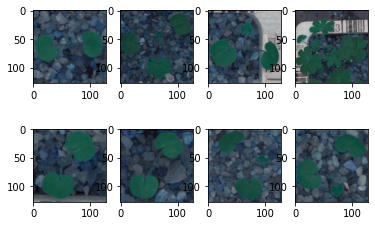

In [79]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])

 

# Apply image processing on the images:

- Gaussian Blurring.
- Normalization.
- Visualize data after pre-processing.

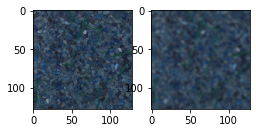

In [80]:
preprocessed_images = []       # Initialize empty list to store the images after pre-processing.

for img in images:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
     
    
    preprocessed_images.append(blurImg)        # Append image 
    
    # Show examples

plt.subplot(1, 3, 1); plt.imshow(img)         # Show the original image
plt.subplot(1, 3, 2); plt.imshow(blurImg)     # Blur image

preprocessed_images = np.asarray(preprocessed_images)    # Convert to numpy array.


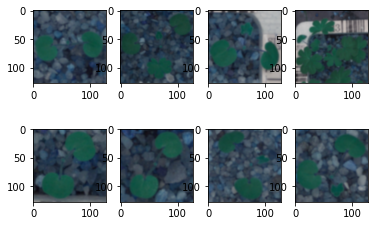

In [81]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(preprocessed_images[i])

In [82]:
# Normalize image data.
preprocessed_images = preprocessed_images / 255

# Make data compatible:

- Convert labels from digits to one hot vectors.
- Print the label for y_train[0].
- Check the shape of data, Reshape data into shapes compatible with Keras models, if already not compatible.


In [83]:
labels.loc[0]

Label    Small-flowered Cranesbill
Name: 0, dtype: object

In [84]:
# Convert labels from digits to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(labels)
# Transform labels - each labels as digits 

In [85]:
# Keep the dataframe for later use
df_enc_dec = pd.DataFrame({'Encode' : list(np.argmax(y,axis=1)),'label':list(labels['Label'])}).drop_duplicates()
df_enc_dec

,Encode,label
0,10,Small-flowered Cranesbill
496,5,Fat Hen
971,9,Shepherds Purse
1202,4,Common wheat
1423,3,Common Chickweed
2034,1,Charlock
2424,2,Cleavers
2711,8,Scentless Mayweed
3227,11,Sugar beet
3612,7,Maize


In [86]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [87]:
print(preprocessed_images.shape[0] * 0.7)
print(preprocessed_images.shape[0] * 0.21)
print(preprocessed_images.shape[0] * 0.09)
#Ratios for Deep Learning based on amount of data

3325.0
997.5
427.5


In [88]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(preprocessed_images, y, test_size=0.3, random_state=42,stratify=y)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_temp, Y_temp, test_size=0.7, random_state=42, stratify = Y_temp)

In [89]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(998, 128, 128, 3)
(998, 12)
(427, 128, 128, 3)
(427, 12)


In [90]:
print(np.sum(Y_train,axis=0))
print(np.sum(Y_valid,axis=0))
print(np.sum(Y_test,axis=0))
# Class ?

[184 273 201 428 155 332 458 155 361 162 347 269]
[ 56  82  60 128  46 100 137  46 109  48 105  81]
[23 35 26 55 20 43 59 20 46 21 44 35]


In [91]:
# Reshape data into shapes compatible with Keras models.

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_valid = X_valid.reshape(X_valid.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

So, we can see above that the data was already compatible with Keras, as the shape of data before and after reshaping is same.

# Building CNN:

- Define layers.
- Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy)

In [20]:
# Set the CNN model

batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

# Start of baseline building block architecture similar to VGG seen before

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [22]:
# Set the optimizer and loss function, and compile the model with them.
batch_size = 128
optimizer = Adam(
                  learning_rate=0.0005,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-07,
                  amsgrad=False,
                  name='Adam')
model.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [98]:
# Set epochs = 40, and fit the model. 
history = model.fit(X_train, Y_train, epochs = 120, validation_data = (X_valid,Y_valid),batch_size = batch_size)


Epoch 1/120
26/26 [==============================] - 2s 52ms/step - loss: 8.7634 - accuracy: 0.0924 - val_loss: 2.4806 - val_accuracy: 0.0982
Epoch 2/120
26/26 [==============================] - 1s 43ms/step - loss: 3.8719 - accuracy: 0.1264 - val_loss: 2.4899 - val_accuracy: 0.1002
Epoch 3/120
26/26 [==============================] - 1s 42ms/step - loss: 2.6243 - accuracy: 0.1899 - val_loss: 2.4892 - val_accuracy: 0.1002
Epoch 4/120
26/26 [==============================] - 1s 42ms/step - loss: 2.2196 - accuracy: 0.2377 - val_loss: 2.4837 - val_accuracy: 0.1373
Epoch 5/120
26/26 [==============================] - 1s 42ms/step - loss: 2.0553 - accuracy: 0.2803 - val_loss: 2.4852 - val_accuracy: 0.1373
Epoch 6/120
26/26 [==============================] - 1s 43ms/step - loss: 1.9397 - accuracy: 0.3371 - val_loss: 2.5330 - val_accuracy: 0.1373
Epoch 7/120
26/26 [==============================] - 1s 43ms/step - loss: 1.7696 - accuracy: 0.3915 - val_loss: 2.5867 - val_accuracy: 0.1373
Epoch 

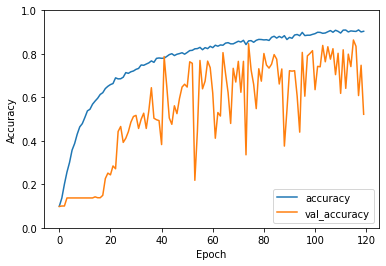

In [100]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');
# What are the spikes for ? - Batch Normalization, Dropout, Learning Rate 

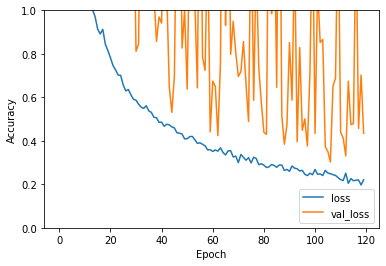

In [82]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

In [40]:
#charts = pd.DataFrame(columns = ['ModelType','Epoch','Accuracy','ValidationAccuracy'])

In [101]:
# Add diff runs to dataframe to analyze data together
temp = pd.DataFrame(columns = ['ModelType','Epoch','Accuracy','ValidationAccuracy'])
Epoch_No = [number for number in range(1,len(history.history['accuracy'])+1)]
modeltype = "FM_4C_256D_BS128_LR0.0005"
modeltype_df = pd.Series(modeltype).repeat(len(history.history['accuracy']))
pd.DataFrame(modeltype_df)
print(len(history.history['accuracy']))
temp['ModelType'] = modeltype_df
temp['Epoch'] = Epoch_No
temp['Accuracy'] = history.history['accuracy']
temp['ValidationAccuracy'] = history.history['val_accuracy']
charts = charts.append(temp, ignore_index=True)

120


In [113]:
charts.iloc[:,0].unique()

array(['FM_4C_256D_BS128_LR0.0001', 'FM_4C_256D_BS128_LR0.001',
       'FM_4C_256D_BS128_LR0.0005'], dtype=object)

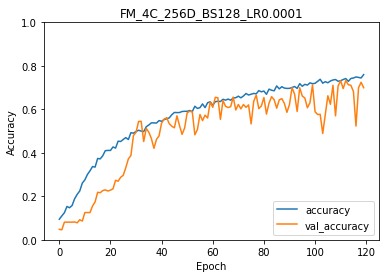

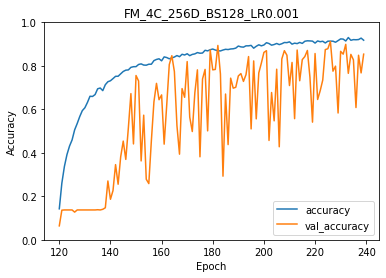

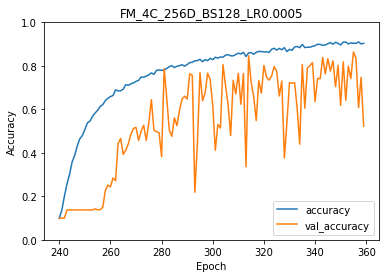

In [114]:
# Plots with different learning rates
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.0001","Accuracy"], label='accuracy')
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.0001","ValidationAccuracy"], label = 'val_accuracy')
plt.title("FM_4C_256D_BS128_LR0.0001")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');
plt.show()
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.001","Accuracy"], label='accuracy')
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.001","ValidationAccuracy"], label = 'val_accuracy')
plt.title("FM_4C_256D_BS128_LR0.001")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');
plt.show()
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.0005","Accuracy"], label='accuracy')
plt.plot(charts.loc[charts["ModelType"]=="FM_4C_256D_BS128_LR0.0005","ValidationAccuracy"], label = 'val_accuracy')
plt.title("FM_4C_256D_BS128_LR0.0005")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');
plt.show()

In [24]:
# Evaluate the model - baseline
score = model.evaluate(X_test, Y_test, verbose=0, batch_size = batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Most accurate idea of how well model perform in production

Test loss: 1.0278913974761963
Test accuracy: 0.6791568994522095


In [43]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid, axis=1)



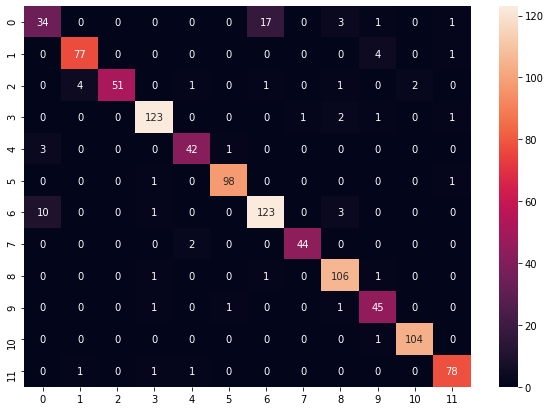

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');


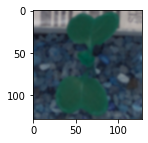

Predicted Label 1
True Label 1


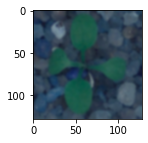

Predicted Label 9
True Label 9


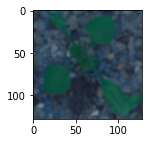

Predicted Label 3
True Label 3


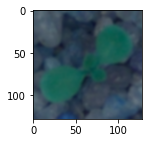

Predicted Label 3
True Label 9


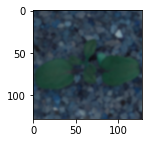

Predicted Label 2
True Label 2


In [47]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(Y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(Y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[33],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[33].reshape(1,128,128,3))))
print('True Label', np.argmax(Y_test[33]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[59].reshape(1,128,128,3))))
print('True Label', np.argmax(Y_test[59]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[36],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model.predict(X_test[36].reshape(1,128,128,3))))
print('True Label', np.argmax(Y_test[36]))
# Take images and put through the model. Train model iterativily so cant have an array - collect data - csv with labels - tedious work 

# Keras HyperParameter Tuner

In [34]:
#!pip install -U keras-tuner

In [127]:
#3 Hyper Parameter tuning for the current model
def build_model(hp):
    model_hp = models.Sequential() # Start model

    for i in range(hp.Int('num_layers1', 0, 3)):
      model_hp.add(layers.Conv2D(filters=hp.Int('filters_' + str(i),min_value=32,max_value=256,step=32), kernel_size = (5, 5), padding='same', activation="relu"))
      model_hp.add(layers.BatchNormalization())
      model_hp.add(layers.MaxPooling2D((2, 2)))
      model_hp.add(layers.Dropout(hp.Float('dropout' + str(i), 0.2, 0.6, step=0.1, default=0.3)))

    for i in range(hp.Int('num_layers2', 0, 3)):
      model_hp.add(layers.Conv2D(filters=hp.Int('filters_' + str(i),min_value=32,max_value=128,step=32), kernel_size =  (3, 3), padding='same', activation="relu"))
      model_hp.add(layers.BatchNormalization())
      model_hp.add(layers.MaxPooling2D((2, 2)))
      model_hp.add(layers.Dropout(hp.Float('dropout' + str(i), 0.2, 0.8, step=0.1, default=0.4)))

    model_hp.add(layers.GlobalMaxPooling2D())
    model_hp.add(layers.Dense(units = hp.Int('units', min_value=64, max_value=512, step=64), activation="relu"))
    model_hp.add(layers.Dropout(hp.Float('dropout_final', 0.2, 0.6, step=0.1, default=0.5)))
    model_hp.add(layers.Dense(12, activation="softmax"))

    
    optimizer = Adam(
                  learning_rate=hp.Float('learning_rate', 1e-3, 1e-6, sampling='log'),  #
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-07,
                  amsgrad=False,
                  name='Adam')

    model_hp.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model_hp

In [130]:
from kerastuner.tuners import BayesianOptimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy', 
    max_trials=30,
    num_initial_points=10,
    seed=255,
    directory='Plant_Dir',
    project_name='Plant_Proj8')

In [131]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers1 (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
num_layers2 (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
dropout_final (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 1e-06, 'step': None, 'sampling': 'log'}


In [132]:
batch_size = 128
tuner.search(X_train, Y_train , epochs = 40, validation_data = (X_valid,Y_valid),batch_size = batch_size)

Trial 30 Complete [00h 01m 03s]
val_accuracy: 0.8076152205467224

Best val_accuracy So Far: 0.882765531539917
Total elapsed time: 00h 32m 22s
INFO:tensorflow:Oracle triggered exit


In [133]:
print(tuner.results_summary())

Results summary
Results in Plant_Dir/Plant_Proj8
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers1: 3
num_layers2: 0
units: 512
dropout_final: 0.6000000000000001
learning_rate: 0.0010000000000000005
filters_0: 32
dropout0: 0.2
filters_1: 128
dropout1: 0.2
filters_2: 128
dropout2: 0.2
Score: 0.882765531539917
Trial summary
Hyperparameters:
num_layers1: 3
num_layers2: 0
units: 512
dropout_final: 0.2
learning_rate: 0.001
filters_0: 128
dropout0: 0.2
filters_1: 128
dropout1: 0.2
filters_2: 32
dropout2: 0.2
Score: 0.8687374591827393
Trial summary
Hyperparameters:
num_layers1: 3
num_layers2: 0
units: 512
dropout_final: 0.2
learning_rate: 0.001
filters_0: 128
dropout0: 0.2
filters_1: 32
dropout1: 0.2
filters_2: 128
dropout2: 0.2
Score: 0.842685341835022
Trial summary
Hyperparameters:
num_layers1: 3
num_layers2: 0
units: 512
dropout_final: 0.2
learning_rate: 0.001
filters_0: 32
dropout0: 0.2
filters_1: 32
dropout1: 0.2
filters_2: 

In [134]:
# Best Hyperparameter model using Baysian CV - This can change on individual machines
print(tuner.get_best_hyperparameters()[0].values)

{'num_layers1': 3, 'num_layers2': 0, 'units': 512, 'dropout_final': 0.6000000000000001, 'learning_rate': 0.0010000000000000005, 'filters_0': 32, 'dropout0': 0.2, 'filters_1': 128, 'dropout1': 0.2, 'filters_2': 128, 'dropout2': 0.2}


In [135]:
# Run test data against best Hyperparametrized Model
best_model = tuner.get_best_models(num_models=1)[0]


In [140]:
best_model.build((None,128,128,3)) 
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0

In [141]:
# Save model for later use
#best_model.save("/content/drive/My Drive/GL_Mentor/KerasModel/Best_Model_HPTuning1_3Layers_LR0.001.h5")


In [23]:
# Reload the best model
best_model = models.load_model("/content/drive/My Drive/GL_Mentor/KerasModel/Best_Model_HPTuning1_3Layers_LR0.001.h5")

In [23]:
#Fitting the model on our training set
batch_size = 256
history_best = best_model.fit(X_train, Y_train, epochs = 2, validation_data = (X_valid,Y_valid),batch_size = batch_size)

Epoch 1/2
13/13 [==============================] - 2s 131ms/step - loss: 0.2470 - accuracy: 0.9224 - val_loss: 0.3913 - val_accuracy: 0.8717
Epoch 2/2
13/13 [==============================] - 1s 109ms/step - loss: 0.2013 - accuracy: 0.9269 - val_loss: 0.4252 - val_accuracy: 0.8527


In [24]:
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0

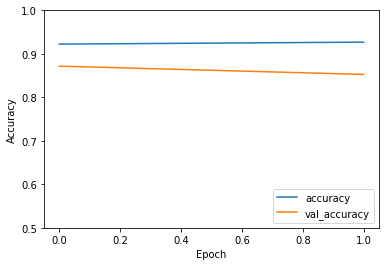

In [25]:
plt.plot(history_best.history['accuracy'], label='accuracy')
plt.plot(history_best.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');


In [26]:
#Improvement in accuracy over the prior model so going in the right direction here
results = best_model.evaluate(X_test, Y_test)
print(best_model.metrics_names)
print(results)

14/14 [==============================] - 0s 12ms/step - loss: 0.5050 - accuracy: 0.8571
['loss', 'accuracy']
[0.504989743232727, 0.8571428656578064]


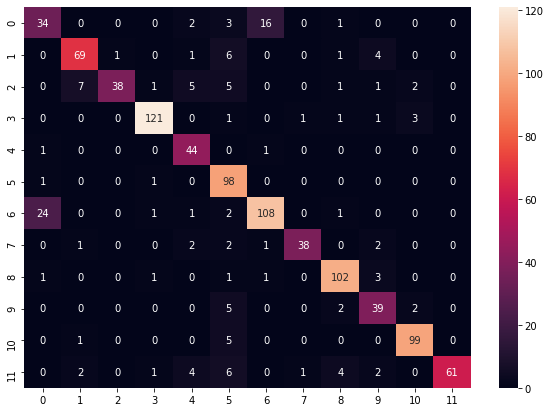

In [27]:
# Predict the values from the validation dataset
Y_pred = best_model.predict(X_valid)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid, axis=1)

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

In [35]:
## Error Analysis
error_analysis = pd.DataFrame({'Actual':Y_true,'Prediction':result})


In [100]:
df_enc_dec

,Encode,label
0,10,Small-flowered Cranesbill
496,5,Fat Hen
971,9,Shepherds Purse
1202,4,Common wheat
1423,3,Common Chickweed
2034,1,Charlock
2424,2,Cleavers
2711,8,Scentless Mayweed
3227,11,Sugar beet
3612,7,Maize


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


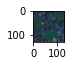

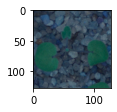

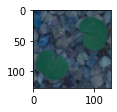

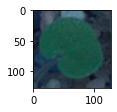

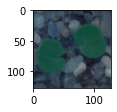

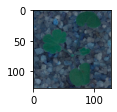

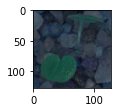

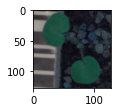

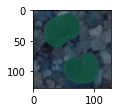

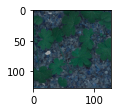

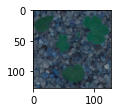

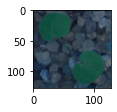

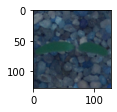

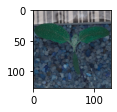

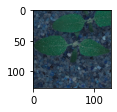

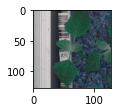

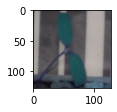

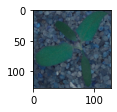

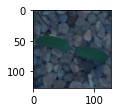

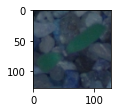

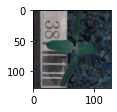

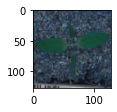

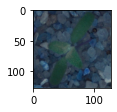

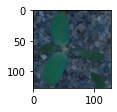

<Figure size 720x720 with 0 Axes>

In [58]:
#Print mislabelled images for error analysis
#Actual - Loose Silky-bent, Predicted - Black-grass
# Print Images with issues and work with stakeholder to figure what the issue might be 
for j,i in enumerate(list(error_analysis[(error_analysis["Actual"] == 6) & (error_analysis["Prediction"] == 0)].index)):
  plt.figure(figsize=(10,10));
  plt.subplot(6,4,j+1); 
  plt.imshow(images[i]);
  
  

# Image Preprocessing to get better Features

In [ ]:
# 2 Preprocess data
'''
project and model specific preprocessing
project - remove irrelevant background from the image
model specific - for transfer learning - whenever use pretrained weights with VGG - Use data as preprocessed the same way as VGG
'''

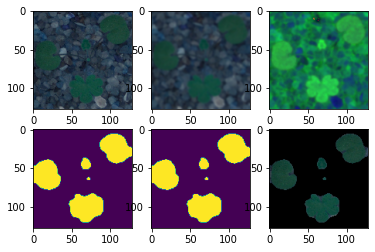

In [92]:
## Use feature engineering to get better data set
lower = (25,40,50)
upper = (75,255,255)
img_preprocess_background = images[1]
blurred = cv2.GaussianBlur(img_preprocess_background,(5,5),0) # Gaussian Blurring to remove noise
hsv = cv2.cvtColor(blurred,cv2.COLOR_BGR2HSV) # convert from RGB to HSV - Hue, Saturation, Value - More resistant to noise / contrast / brightness

mask = cv2.inRange(hsv,lower,upper)  # Hue - color range to 25-75 Green to create mask of interested values

struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) # Get ellipse shape structures
mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # Get ellipse shape firmed out
boolean = mask > 0 # Get key elements in image and rest in background

new = np.zeros_like(img_preprocess_background,np.uint8) #Create a zeros vector similar to background
new[boolean] = img_preprocess_background[boolean] # Add active 1s on top of the new image

plt.subplot(2,3,1); plt.imshow(img_preprocess_background) # ORIGINAL
plt.subplot(2,3,2); plt.imshow(blurred) # BLURRED
plt.subplot(2,3,3); plt.imshow(hsv) # HSV CONVERTED
plt.subplot(2,3,4); plt.imshow(mask) # MASKED
plt.subplot(2,3,5); plt.imshow(boolean) # BOOLEAN MASKED
plt.subplot(2,3,6); plt.imshow(new) # NEW PROCESSED IMAGE
plt.show()
# 1 channel analysis
# Data F

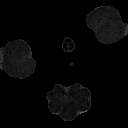

In [93]:
#Analyze across each channel
from google.colab.patches import cv2_imshow
hue_channel = new[:,:,0]
cv2_imshow(hue_channel)

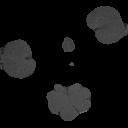

In [94]:
saturation_channel = new[:,:,1]
cv2_imshow(saturation_channel)

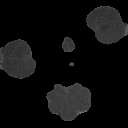

In [95]:
value_channel = new[:,:,2]
cv2_imshow(value_channel)

In [96]:
img_background = []

for img in images:
  img = cv2.resize(img,(64,64))
  blurr = cv2.GaussianBlur(img,(5,5),0)
  hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv,lower,upper)
  struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
  boolean = mask > 0
  new = np.zeros_like(img,np.uint8)
  new[boolean] = img[boolean]
  img_background.append(new)

img_background = np.asarray(img_background)

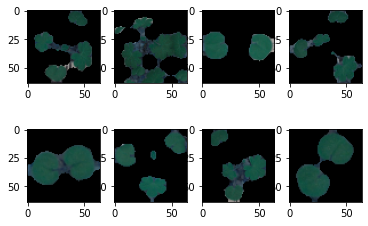

In [97]:
# CLEANED IMAGES
for i in range(200,208):
  plt.subplot(2,4,208-i)
  plt.imshow(img_background[i])


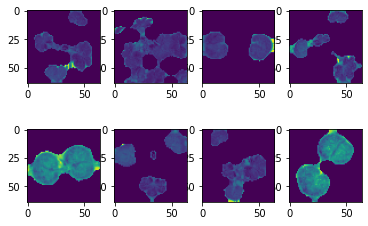

In [98]:
# CLEANED IMAGES - Hue value only
for i in range(200,208):
  plt.subplot(2,4,208-i)
  plt.imshow(img_background[i][:,:,0])

In [99]:
img_background = img_background / 255
X_train_v2, X_temp_v2, Y_train_v2, Y_temp_v2 = train_test_split(img_background, y, test_size=0.3, random_state=42,stratify=y)
X_test_v2, X_valid_v2, Y_test_v2, Y_valid_v2 = train_test_split(X_temp_v2, Y_temp_v2, test_size=0.7, random_state=42, stratify = Y_temp_v2)

In [25]:
# Set epochs = 40, and fit the model. 
batch_size = 256
history_background = best_model.fit(X_train_v2, Y_train_v2, epochs = 75, validation_data = (X_valid_v2,Y_valid_v2),batch_size = batch_size)

Epoch 1/75
13/13 [==============================] - 4s 110ms/step - loss: 2.0638 - accuracy: 0.3459 - val_loss: 2.2456 - val_accuracy: 0.3497
Epoch 2/75
13/13 [==============================] - 0s 33ms/step - loss: 1.3623 - accuracy: 0.5281 - val_loss: 2.2757 - val_accuracy: 0.3858
Epoch 3/75
13/13 [==============================] - 0s 33ms/step - loss: 1.1330 - accuracy: 0.5961 - val_loss: 2.0671 - val_accuracy: 0.4990
Epoch 4/75
13/13 [==============================] - 0s 33ms/step - loss: 0.9850 - accuracy: 0.6598 - val_loss: 1.8625 - val_accuracy: 0.4870
Epoch 5/75
13/13 [==============================] - 0s 33ms/step - loss: 0.8702 - accuracy: 0.6959 - val_loss: 1.8770 - val_accuracy: 0.4599
Epoch 6/75
13/13 [==============================] - 0s 33ms/step - loss: 0.7858 - accuracy: 0.7254 - val_loss: 1.6239 - val_accuracy: 0.5170
Epoch 7/75
13/13 [==============================] - 0s 33ms/step - loss: 0.7265 - accuracy: 0.7534 - val_loss: 1.5848 - val_accuracy: 0.5431
Epoch 8/75
1

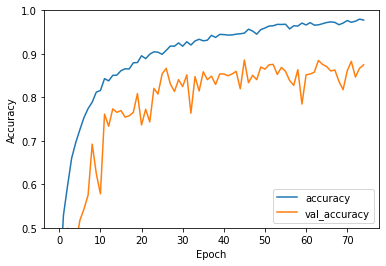

In [26]:
plt.plot(history_background.history['accuracy'], label='accuracy')
plt.plot(history_background.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

In [31]:
results = best_model.evaluate(X_test_v2, Y_test_v2)
print(best_model.metrics_names)
print(results)

14/14 [==============================] - 0s 6ms/step - loss: 0.8189 - accuracy: 0.8407
['loss', 'accuracy']
[0.8188718557357788, 0.8407494425773621]


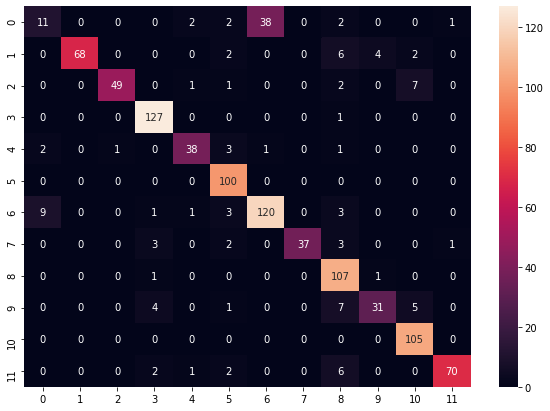

In [32]:
# Predict the values from the validation dataset
Y_pred_v2 = best_model.predict(X_valid_v2)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred_v2, axis=1)
# Convert validation observations to one hot vectors
Y_true_v2 = np.argmax(Y_valid_v2, axis=1)

conf_mat = confusion_matrix(Y_true_v2, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

In [109]:
## Single channel analysis with Hue only - Feel free to change and test on the other two - S & V

img_background_sc = np.zeros((4750,64,64,1))
for i in range(0,img_background.shape[0]):
  img_background_sc[i] = img_background[i][:,:,0].reshape(64,64,1)

In [110]:
X_train_v3, X_temp_v3, Y_train_v3, Y_temp_v3 = train_test_split(img_background_sc, y, test_size=0.3, random_state=42,stratify=y)
X_test_v3, X_valid_v3, Y_test_v3, Y_valid_v3 = train_test_split(X_temp_v3, Y_temp_v3, test_size=0.7, random_state=42, stratify = Y_temp_v3)

In [115]:
# Set the CNN model for Single Channel - Hue ( Didnt get any good accuracy)
batch_size = 256

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=(128, 128, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

batch_size = 128
optimizer = Adam(
                  learning_rate=0.0005,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-07,
                  amsgrad=False,
                  name='Adam')
model.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


# Set epochs = 40, and fit the model. 
batch_size = 256
history_background = model.fit(X_train_v3, Y_train_v3, epochs = 25, validation_data = (X_valid_v3,Y_valid_v3),batch_size = batch_size)

Epoch 1/25
13/13 [==============================] - 1s 40ms/step - loss: 6.5745 - accuracy: 0.0961 - val_loss: 2.4796 - val_accuracy: 0.1373
Epoch 2/25
13/13 [==============================] - 0s 25ms/step - loss: 4.4065 - accuracy: 0.1071 - val_loss: 2.4705 - val_accuracy: 0.1373
Epoch 3/25
13/13 [==============================] - 0s 24ms/step - loss: 3.2948 - accuracy: 0.0998 - val_loss: 2.4634 - val_accuracy: 0.1373
Epoch 4/25
13/13 [==============================] - 0s 25ms/step - loss: 2.7976 - accuracy: 0.0911 - val_loss: 2.4667 - val_accuracy: 0.1373
Epoch 5/25
13/13 [==============================] - 0s 24ms/step - loss: 2.5941 - accuracy: 0.1033 - val_loss: 2.4815 - val_accuracy: 0.0822
Epoch 6/25
13/13 [==============================] - 0s 24ms/step - loss: 2.5271 - accuracy: 0.1104 - val_loss: 2.5003 - val_accuracy: 0.0822
Epoch 7/25
13/13 [==============================] - 0s 24ms/step - loss: 2.4764 - accuracy: 0.1145 - val_loss: 2.5258 - val_accuracy: 0.0822
Epoch 8/25
13

# Image Data Generator

In [ ]:
## Code for Image Data Generator below - Here we load the training data in batches and train using 
# the best model we already have. Feel free to use the below mentioned approach to train from start

In [4]:
#Code to be run only once to unzip the file in folders and files
import math 
import numpy as np 
import pandas as pd 
from glob import glob 
data_path = '/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/plant-seedlings-classification.zip' 
!mkdir dataset 
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.) 
from zipfile import ZipFile 
with ZipFile(data_path, 'r') as zip: 
  zip.extractall('/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset') 
  #path = "/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/*/*.*" 
  # The path to all images in training set. (* means include all folders and files.) 
  #files = glob(path)  
  #num = len(files) 
  zip.close()


mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
#Standard dataset directory structure (In our case we have this strcuture for training set only from Kaggle)
#Below structure required to run imagedatagenerator
data/
data/train/
data/train/class1/
data/train/class2/
data/test/
data/test/class1
data/test/class2

In [30]:
# Get the test data seperately to make final predictions
path = '/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/test/*.*'
files = glob(path) 
testImg = []  # Initialize empty list to store the image data as numbers.  
# Obtain images and resizing, obtain labels 
for img in files:
	testImg.append(cv2.resize(cv2.imread(img), (128, 128)))
testImg = np.asarray(testImg) 
# Test images set 
print(testImg.shape) 
np.save('/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/test_plant_images.npy', testImg)

(794, 128, 128, 3)


In [66]:
best_model = models.load_model("/content/drive/My Drive/GL_Mentor/KerasModel/Best_Model_HPTuning1_3Layers_LR0.001.h5")


In [67]:
def preprocess_blur(img):
  blurImg = cv2.GaussianBlur(img, (5, 5), 0) 
  return(blurImg)

In [68]:
#Create train and validation data generators
datagen_train = ImageDataGenerator(rescale=1./255.,validation_split=0.2, preprocessing_function=preprocess_blur)
# load and iterate training dataset
train_it = datagen_train.flow_from_directory('/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/train', 
                                       target_size=(128, 128),
                                       class_mode='categorical', 
                                       batch_size=256,
                                       subset='training',
                                       seed=42)
valid_it = datagen_train.flow_from_directory('/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/train',
                                                   target_size=(128, 128),
                                                   batch_size=256,
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   seed=42)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [69]:
#Train model using the train and test data
batch_size = 256

STEP_SIZE_TRAIN=train_it.n//train_it.batch_size
STEP_SIZE_VALID=valid_it.n//valid_it.batch_size

best_model.fit(train_it,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_it,
          validation_steps=STEP_SIZE_VALID,
          epochs=15)



Epoch 1/15
14/14 [==============================] - 55s 4s/step - loss: 1.5376 - accuracy: 0.5213 - val_loss: 6.0874 - val_accuracy: 0.1719
Epoch 2/15
14/14 [==============================] - 51s 4s/step - loss: 0.8017 - accuracy: 0.7229 - val_loss: 6.7325 - val_accuracy: 0.1940
Epoch 3/15
14/14 [==============================] - 51s 4s/step - loss: 0.5765 - accuracy: 0.8035 - val_loss: 7.7019 - val_accuracy: 0.2057
Epoch 4/15
14/14 [==============================] - 52s 4s/step - loss: 0.4654 - accuracy: 0.8337 - val_loss: 5.8691 - val_accuracy: 0.2721
Epoch 5/15
14/14 [==============================] - 51s 4s/step - loss: 0.4434 - accuracy: 0.8472 - val_loss: 4.1466 - val_accuracy: 0.2943
Epoch 6/15
14/14 [==============================] - 51s 4s/step - loss: 0.3555 - accuracy: 0.8754 - val_loss: 5.0437 - val_accuracy: 0.2826
Epoch 7/15
14/14 [==============================] - 52s 4s/step - loss: 0.3239 - accuracy: 0.8889 - val_loss: 2.8766 - val_accuracy: 0.3815
Epoch 8/15
14/14 [==

In [70]:
test_data = np.load('/content/drive/My Drive/GL_Mentor/Data/PlantSeedlings/dataset/test_plant_images.npy')
test_data.shape

(794, 128, 128, 3)

In [71]:
#Predictions on Final Test Data Set
y_predict = best_model.predict(test_data)
np.argmax(y_predict,axis=1)

array([7, 6, 6, 8, 8, 6, 8, 8, 6, 6, 8, 8, 8, 8, 6, 8, 8, 8, 8, 6, 8, 8,
       8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 8, 6, 6, 6, 6, 8, 8, 7, 6, 8, 1,
       8, 8, 7, 8, 8, 8, 6, 8, 8, 6, 8, 8, 6, 8, 8, 6, 8, 6, 8, 6, 8, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 6, 6, 8, 8, 6, 6, 8, 8, 6, 8, 6, 8, 6,
       8, 6, 8, 6, 8, 6, 8, 6, 7, 8, 8, 8, 8, 8, 8, 6, 6, 8, 8, 8, 7, 8,
       6, 8, 8, 8, 8, 6, 8, 8, 8, 8, 7, 6, 8, 6, 8, 6, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 6, 6, 8, 6, 8, 6, 8, 8, 8, 8, 6, 6, 8, 8, 8, 8, 6, 8, 8,
       6, 8, 1, 6, 6, 8, 8, 6, 8, 8, 8, 6, 8, 6, 8, 8, 8, 8, 1, 8, 8, 8,
       6, 6, 6, 6, 6, 8, 6, 8, 6, 8, 8, 8, 8, 8, 6, 8, 8, 6, 8, 6, 6, 8,
       6, 8, 8, 6, 8, 8, 8, 6, 6, 8, 6, 8, 8, 8, 6, 6, 8, 6, 8, 6, 8, 8,
       8, 6, 8, 8, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 1, 8, 7, 8,
       8, 8, 8, 1, 6, 6, 8, 8, 8, 6, 1, 8, 1, 6, 6, 7, 8, 8, 6, 7, 8, 8,
       8, 8, 6, 8, 8, 8, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 6, 6, 8, 6, 8, 6,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 8, 6, 8,